In [ ]:
import sys
import json
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt

sys.path.append('/code_location/multi_gpu/')
import functions_brain_network

import arch_generate_random_CNN
import importlib
importlib.reload(arch_generate_random_CNN)


In [ ]:
success = False

while not success:
    try:
        brain_net_architecture, repeating_cnn_elements = arch_generate_random_CNN.get_random_cnn_architecture()

        n_classes_dict = {'f0_label':700}

        tf.reset_default_graph()
        input_tensor = tf.placeholder(tf.float32, shape=[None, 100, 1000, 1], name='input_nervegrams')
        output_tensor, nets = functions_brain_network.make_brain_net(input_tensor,
                                                                     n_classes_dict,
                                                                     brain_net_architecture,
                                                                     trainable=True,
                                                                     batchnorm_flag=True,
                                                                     dropout_flag=True,
                                                                     save_arch_path=None,
                                                                     save_pckl_path=None,
                                                                     only_include_layers=None)
        success = True
    except ValueError:
        print('REPEAT')

print('----> INPUT:', input_tensor.shape)
for layer_dict in brain_net_architecture:
    key = layer_dict['args']['name']
    if 'conv' in key:
        print('------ {} ------'.format(key))
    if 'pool' in key or 'conv' in key:
        print(layer_dict['args'])
    print(key, nets[key].shape)

    

print('----> OUTPUT:', output_tensor.shape)

In [ ]:
def get_possible_arch(n_classes_dict={'f0_label':700}):
    success = False
    count = 0
    while not success:
#         new_net = arch_generate_random_CNN.RandomCNN()
        try:
#             brain_net_architecture = new_net.all_layer_list
            brain_net_architecture, repeating_cnn_elements = arch_generate_random_CNN.get_random_cnn_architecture()
            tf.reset_default_graph()
            input_tensor = tf.placeholder(tf.float32, shape=[None, 100, 1000, 1], name='input_nervegrams')
            output_tensor, nets = functions_brain_network.make_brain_net(input_tensor,
                                                                         n_classes_dict,
                                                                         brain_net_architecture,
                                                                         trainable=True,
                                                                         batchnorm_flag=True,
                                                                         dropout_flag=True,
                                                                         save_arch_path=None,
                                                                         save_pckl_path=None,
                                                                         only_include_layers=None)
            success = True
        except ValueError:
            count += 1
#             print(count, len(new_net.num_conv_kernels))
            pass
    return brain_net_architecture, repeating_cnn_elements['conv_layer_count'], count, nets


n_list = []
arch_list = []
nets_list = []
count = 0
for _ in range(100):
    arch, n, count_i, nets = get_possible_arch()
    n_list.append(n)
    arch_list.append(arch)
    nets_list.append(nets)
    count += count_i
    print(_, count)

In [ ]:
plt.figure()
plt.hist(n_list, 8)
plt.show()

In [ ]:
IDX = np.random.randint(len(arch_list))
print(IDX)
arch = arch_list[IDX]
nets = nets_list[IDX]
for layer_dict in arch:
    layer_name = layer_dict['args']['name']
    if 'conv' in layer_name:
        print('------ {} ------'.format(layer_name))
        print(nets[layer_name].shape)


In [3]:
import sys
import os
import json
import glob
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

valid_format = '/om/scratch/Fri/msaddler/pitchnet/saved_models/arch_search_v01/arch_{:04d}/validation_metrics.json'
brain_format = '/om/scratch/Fri/msaddler/pitchnet/saved_models/arch_search_v01/arch_{:04d}/brain_arch.json'


def get_valid_trace(valid_metrics_fn, metric_key='f0_label:accuracy', checkpoint_number_key='step'):
    '''
    '''
    with open(valid_metrics_fn) as f: valid_metrics_dict = json.load(f)
    metric_values = valid_metrics_dict[metric_key]
    valid_step = valid_metrics_dict[checkpoint_number_key]
    ### START: WORK AROUND FOR BUG CAUSED BY PREEMPTING AND RESTARTING TRAINING (valid step is reset)
    checkpoint_numbers = [valid_step[0]]
    for idx, diff in enumerate(np.diff(valid_step)):
        if diff > 0: checkpoint_numbers.append(checkpoint_numbers[-1] + diff)
        else: checkpoint_numbers.append(checkpoint_numbers[-1] + valid_step[idx+1])
    assert len(checkpoint_numbers) == len(valid_step)
    assert len(checkpoint_numbers) == len(metric_values)
    ### END: WORK AROUND FOR BUG CAUSED BY PREEMPTING AND RESTARTING TRAINING (valid step is reset)
    return checkpoint_numbers, metric_values


def calc_num_layers(brain_arch_fn):
    with open(brain_arch_fn) as f: brain_arch = json.load(f)
    num_conv_layers = 0
    for layer_dict in brain_arch:
        if layer_dict['layer_type'] == 'tf.layers.conv2d':
            num_conv_layers = num_conv_layers + 1
    return num_conv_layers


def calc_best_metric(valid_metrics_fn, metric_key='f0_label:accuracy', maximize=True):
    '''
    '''
    with open(valid_metrics_fn) as f: valid_metrics_dict = json.load(f)
    metric_values = valid_metrics_dict[metric_key]
    if maximize: best_metric_value = np.max(metric_values)
    else: best_metric_value = np.min(metric_values)
    return best_metric_value


list_traces = []
list_num_layers = []
list_best_metric = []
list_arch_nums = []

for idx in range(750):
    brain_arch_fn = brain_format.format(idx)
    valid_metrics_fn = valid_format.format(idx)
    
    if os.path.exists(brain_arch_fn) and os.path.exists(valid_metrics_fn):
        list_traces.append(get_valid_trace(valid_metrics_fn))
        list_num_layers.append(calc_num_layers(brain_arch_fn))
        list_best_metric.append(calc_best_metric(valid_metrics_fn))
        list_arch_nums.append(idx)
        

In [6]:
list_num_layers = np.array(list_num_layers)
list_best_metric = np.array(list_best_metric)
list_arch_nums = np.array(list_arch_nums)

arch_nums_for_each_num_layers = []
for nl in np.unique(list_num_layers):
    sublist_best_metric = list_best_metric[list_num_layers == nl]
    sublist_arch_nums = list_arch_nums[list_num_layers == nl]
    
    IDX = np.argsort(sublist_best_metric)[len(sublist_best_metric)//2]
    
#     IDX = np.argmax(sublist_best_metric)
    print(sublist_arch_nums[IDX], sublist_best_metric[IDX], nl)
    
    arch_nums_for_each_num_layers.append(sublist_arch_nums[IDX])

arch_nums_for_each_num_layers

185 0.10946310311555862 1
349 0.1693795770406723 2
76 0.18094712495803833 3
244 0.184342622756958 4
340 0.1804208904504776 5
277 0.18542365729808807 6
307 0.17168927192687988 7
289 0.16941052675247192 8


[185, 349, 76, 244, 340, 277, 307, 289]

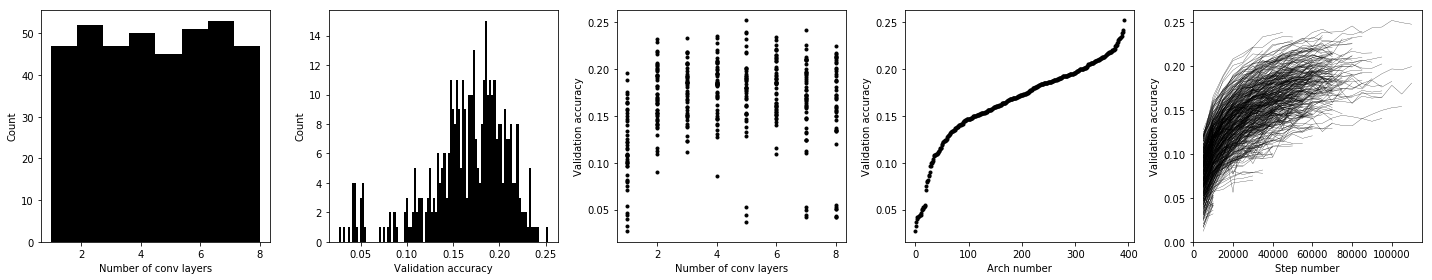

In [7]:
NCOLS = 5
NROWS = 1
fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(4*NCOLS, 4*NROWS))
ax = ax.flatten()

ax[0].hist(list_num_layers, 8, color='k')
ax[0].set_xlabel('Number of conv layers')
ax[0].set_ylabel('Count')
ax[1].hist(list_best_metric, 100, color='k')
ax[1].set_xlabel('Validation accuracy')
ax[1].set_ylabel('Count')
ax[2].plot(list_num_layers, list_best_metric, 'k.')
ax[2].set_xlabel('Number of conv layers')
ax[2].set_ylabel('Validation accuracy')
ax[3].plot(np.sort(list_best_metric), 'k.')
ax[3].set_xlabel('Arch number')
ax[3].set_ylabel('Validation accuracy')

for idx, (checkpoint_numbers, metric_values) in enumerate(list_traces):
    if list_num_layers[idx] > 0:
        ax[4].plot(checkpoint_numbers, metric_values, ls='-', lw=0.25, color='k')
    else:
        ax[4].plot(checkpoint_numbers, metric_values, ls='-', lw=0.25, color='b')
ax[4].set_xlabel('Step number')
ax[4].set_ylabel('Validation accuracy')

plt.tight_layout()
plt.show()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_12_05_PNDv08_archSearch01/'
# fig.savefig(os.path.join(save_dir, '2019DEC04_arch_search_v01_summary.pdf'), bbox_inches='tight')


In [8]:
metric_sort_idx = np.argsort(list_best_metric)
bidx = metric_sort_idx[-10]
print(list_arch_nums[bidx], list_best_metric[bidx], list_num_layers[bidx])

343 0.2319629043340683 5


In [ ]:
import os
import json

output_dir = '/om2/user/msaddler/pitchnet/saved_models/PND_v04_TLAS_classification0'
arch_fn = os.path.join(output_dir, 'brain_arch.json')

arch_fn_list = [
'/om/scratch/Sun/msaddler/pitchnet/saved_models/arch_search_v00/arch_0703/brain_arch.json',
'/om/scratch/Sun/msaddler/pitchnet/saved_models/arch_search_v00/arch_0693/brain_arch.json',
'/om/scratch/Sun/msaddler/pitchnet/saved_models/arch_search_v00/arch_0156/brain_arch.json',
'/om/scratch/Sun/msaddler/pitchnet/saved_models/arch_search_v00/arch_0051/brain_arch.json',
'/om/scratch/Sun/msaddler/pitchnet/saved_models/arch_search_v00/arch_0342/brain_arch.json',
'/om/scratch/Sun/msaddler/pitchnet/saved_models/arch_search_v00/arch_0664/brain_arch.json',
# '/om/scratch/Sun/msaddler/pitchnet/saved_models/arch_search_v00/arch_0084/brain_arch.json',
# '/om/scratch/Sun/msaddler/pitchnet/saved_models/arch_search_v00/arch_0265/brain_arch.json',
# '/om/scratch/Sun/msaddler/pitchnet/saved_models/arch_search_v00/arch_0637/brain_arch.json',
# '/om/scratch/Sun/msaddler/pitchnet/saved_models/arch_search_v00/arch_0086/brain_arch.json',
# '/om/scratch/Sun/msaddler/pitchnet/saved_models/arch_search_v00/arch_0254/brain_arch.json',
# '/om/scratch/Sun/msaddler/pitchnet/saved_models/arch_search_v00/arch_0416/brain_arch.json',
]

# arch_fn_list = [
# '/om/scratch/Sun/msaddler/pitchnet/saved_models/arch_search_v00/arch_0628/brain_arch.json',
# '/om/scratch/Sun/msaddler/pitchnet/saved_models/arch_search_v00/arch_0374/brain_arch.json',
# '/om/scratch/Sun/msaddler/pitchnet/saved_models/arch_search_v00/arch_0471/brain_arch.json',
# '/om/scratch/Sun/msaddler/pitchnet/saved_models/arch_search_v00/arch_0018/brain_arch.json',
# '/om/scratch/Sun/msaddler/pitchnet/saved_models/arch_search_v00/arch_0610/brain_arch.json',
# '/om/scratch/Sun/msaddler/pitchnet/saved_models/arch_search_v00/arch_0429/brain_arch.json',
# # '/om/scratch/Sun/msaddler/pitchnet/saved_models/arch_search_v00/arch_0721/brain_arch.json',
# # '/om/scratch/Sun/msaddler/pitchnet/saved_models/arch_search_v00/arch_0282/brain_arch.json',
# # '/om/scratch/Sun/msaddler/pitchnet/saved_models/arch_search_v00/arch_0682/brain_arch.json',
# # '/om/scratch/Sun/msaddler/pitchnet/saved_models/arch_search_v00/arch_0533/brain_arch.json',
# # '/om/scratch/Sun/msaddler/pitchnet/saved_models/arch_search_v00/arch_0466/brain_arch.json',
# # '/om/scratch/Sun/msaddler/pitchnet/saved_models/arch_search_v00/arch_0284/brain_arch.json',
# ]

for arch_fn in arch_fn_list:

    with open(arch_fn) as f:
        arch_list = json.load(f)
    print('_' * len(arch_fn))
    print(arch_fn)
    for layer in arch_list:
        if layer['layer_type'] == 'tf.layers.conv2d':
            print('layer: {} | kernel_shape: {} | filters: {}'.format(
                layer['args']['name'], layer['args']['kernel_size'], layer['args']['filters']))
        elif 'pool' in layer['layer_type']:
            print('layer: {} | strides: {} | pool_size: {}'.format(
                layer['args']['name'], layer['args']['strides'], layer['args']['pool_size']))
        elif layer['layer_type'] == 'tf.layers.dense':
            print('layer: {} | units: {}'.format(
                layer['args']['name'], layer['args']['units']))
        elif layer['layer_type'] in ['tf.nn.relu',
                                     'tf.layers.batch_normalization',
                                     'tf.layers.dropout',
                                     'fc_top_classification'
                                    ]:
            print('layer: {}'.format(layer['args']['name']))

In [ ]:
import arch_generate_random_CNN
import importlib
importlib.reload(arch_generate_random_CNN)

for _ in range(20):
    layer_list, repeating_cnn_elements = arch_generate_random_CNN.get_random_cnn_architecture()
#         kwargs_sample_repeating_cnn_elements={'max_kernel_area':100})
    conv_layer_count = repeating_cnn_elements['conv_layer_count']
    print('----')
    for layer_index in range(conv_layer_count):
        kernel_shapes = repeating_cnn_elements['conv_kernel_shapes'][layer_index]
        kernel_depths = repeating_cnn_elements['conv_kernel_depths'][layer_index]
        pool_strides = repeating_cnn_elements['pool_strides'][layer_index]
        print(layer_index, kernel_shapes+[kernel_depths], pool_strides)
    

In [1]:
import sys
import os
import json
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt

sys.path.append('/code_location/multi_gpu/')
import functions_brain_network

import arch_generate_random_CNN
import arch_generate_output_directory
import importlib


def modify_arch(brain_net_architecture,
                list_factor_dim1=[1, 1, 1, 1, 1],
                list_max_dim1=[100, 100, 100, 34, 34],
                verbose=True):
    '''
    '''
    if not isinstance(list_factor_dim1, list):
        list_factor_dim1 = [list_factor_dim1] * len(list_max_dim1)
    
    layer_idx = 0
    for layer_dict in brain_net_architecture:
        if layer_dict['layer_type'] == 'tf.layers.conv2d':
            max_dim1 = list_max_dim1[layer_idx]
            factor_dim1 = list_factor_dim1[layer_idx]
            [dim1, dim2] = layer_dict['args']['kernel_size']
            
            old_area = dim1 * dim2
            dim1_new = np.ceil(dim1 * factor_dim1).astype(int)
            dim1_new = min(max_dim1, dim1_new)
            dim2_new = np.ceil(old_area / dim1_new).astype(int)
            new_area = dim1_new * dim2_new
            
            layer_dict['args']['kernel_size'] = [dim1_new, dim2_new]
            
            if verbose:
                print('conv_{}: {}-->{}, {}-->{}'.format(layer_idx,
                                                         [dim1, dim2],
                                                         [dim1_new, dim2_new],
                                                         old_area,
                                                         new_area))
            
            layer_idx += 1
            
    return brain_net_architecture


def modify_arch_first_layer(brain_net_architecture,
                            factor_dim1=1,
                            factor_dim2=1,
                            verbose=True):
    '''
    '''
    for layer_dict in brain_net_architecture:
        if layer_dict['layer_type'] == 'tf.layers.conv2d':
            [dim1, dim2] = layer_dict['args']['kernel_size']
            dim1_new = np.round(dim1 * factor_dim1).astype(int)
            dim2_new = np.round(dim2 * factor_dim2).astype(int)
            layer_dict['args']['kernel_size'] = [dim1_new, dim2_new]
            if verbose:
                print('conv_{}: {}-->{}'.format(0, [dim1, dim2], [dim1_new, dim2_new]))
            
            break
    return brain_net_architecture


In [6]:
# Max possible dim2 scaling factor = 1.56 (leads to kernel with length 390 in time dimension)

# manipulation_list = [(1, x) for x in np.arange(0.1, 1.561, 0.05)] # arch_search_v01_arch_0302_manipulations_v01
# manipulation_list = [] # arch_search_v01_arch_0302_manipulations_v02
# for factor_dim1 in [1, 2, 4, 8, 16, 32]:
#     for factor_dim2 in [1.0, 0.4, 0.1, 0.04, 0.02]:
#         manipulation_list.append((factor_dim1, factor_dim2))
manipulation_list = [(x, 1/x) for x in np.arange(1, 31)] # arch_search_v01_arch_0302_manipulations_v03

print(len(manipulation_list))

# Baseline architecture
brain_arch_fn = '/om/scratch/Mon/msaddler/pitchnet/saved_models/arch_search_v01_arch_0302_manipulations/brain_arch_0302validtime.json'

# Filename format for saving modified architectures and creating output directories
new_arch_fn_format = '/om/scratch/Mon/msaddler/pitchnet/saved_models/arch_search_v01_arch_0302_manipulations_v03/arch_0302_{:04d}/brain_arch.json'

for arch_IDX, (factor_dim1, factor_dim2) in enumerate(manipulation_list):
    with open(brain_arch_fn) as f:
        brain_net_architecture = json.load(f)
    # Create new architecture config
    brain_net_architecture = modify_arch_first_layer(brain_net_architecture,
                                                     factor_dim1=factor_dim1,
                                                     factor_dim2=factor_dim2,
                                                     verbose=True)
    # Test new architecture config
    tf.reset_default_graph()
    n_classes_dict = {'f0_label':700}
    batch_size = 128
    input_tensor = tf.placeholder(tf.float32, shape=[batch_size, 100, 1000, 1], name='input_nervegrams')
    output_tensor, nets = functions_brain_network.make_brain_net(input_tensor,
                                                                 n_classes_dict,
                                                                 brain_net_architecture,
                                                                 trainable=True,
                                                                 batchnorm_flag=True,
                                                                 dropout_flag=True,
                                                                 save_arch_path=None,
                                                                 save_pckl_path=None,
                                                                 only_include_layers=None)
    print('--- TENSORS ---')
    for key in ['flatten_end_conv']:#sorted(nets.keys()):
        print(key, nets[key])
    
    # Save new architecture config
    new_arch_fn = new_arch_fn_format.format(arch_IDX)
    print(new_arch_fn)
    
#     output_dir, basename = os.path.split(new_arch_fn)
#     if not os.path.exists(output_dir):
#         os.mkdir(output_dir)
#     arch_generate_output_directory.save_network_architecture(brain_net_architecture, new_arch_fn)


30
conv_0: [1, 250]-->[1, 250]
--- TENSORS ---
flatten_end_conv Tensor("flatten_end_conv/Reshape:0", shape=(128, 30720), dtype=float32)
/om/scratch/Mon/msaddler/pitchnet/saved_models/arch_search_v01_arch_0302_manipulations_v03/arch_0302_0000/brain_arch.json
conv_0: [1, 250]-->[2, 125]
--- TENSORS ---
flatten_end_conv Tensor("flatten_end_conv/Reshape:0", shape=(128, 49152), dtype=float32)
/om/scratch/Mon/msaddler/pitchnet/saved_models/arch_search_v01_arch_0302_manipulations_v03/arch_0302_0001/brain_arch.json
conv_0: [1, 250]-->[3, 83]
--- TENSORS ---
flatten_end_conv Tensor("flatten_end_conv/Reshape:0", shape=(128, 55296), dtype=float32)
/om/scratch/Mon/msaddler/pitchnet/saved_models/arch_search_v01_arch_0302_manipulations_v03/arch_0302_0002/brain_arch.json
conv_0: [1, 250]-->[4, 62]
--- TENSORS ---
flatten_end_conv Tensor("flatten_end_conv/Reshape:0", shape=(128, 61440), dtype=float32)
/om/scratch/Mon/msaddler/pitchnet/saved_models/arch_search_v01_arch_0302_manipulations_v03/arch_0302_

In [4]:
manipulation_list = [
    # Original (with valid padding)
    [1, 1, 1, 1, 1],

    # Perturbations to make filters shorter in freq and longer in time
    [1, 0.3, 1, 1, 1],
    [1, 0.35, 1, 1, 1],
    [1, 0.4, 1, 1, 1],
    [1, 0.45, 1, 1, 1],
    [1, 0.5, 1, 1, 1],
    [1, 0.55, 1, 1, 1],
    [1, 0.6, 1, 1, 1],
    [1, 0.65, 1, 1, 1],
    [1, 0.7, 1, 1, 1],
    [1, 0.75, 1, 1, 1],
    [1, 0.8, 1, 1, 1],
    [1, 0.85, 1, 1, 1],
    [1, 0.9, 1, 1, 1],
    [1, 0.95, 1, 1, 1],
    [1, 1, 0.7, 1, 1],
    [1, 1, 0.8, 1, 1],
    [1, 1, 0.9, 1, 1],
    [1, 1, 1, 0.7, 1],
    [1, 1, 1, 0.8, 1],
    [1, 1, 1, 1, 0.6],
    [1, 1, 1, 1, 0.8],
    
    # Perturbations to make filters longer in freq and shorter in time
    [1, 1.2, 1, 1, 1],
    [1, 1.4, 1, 1, 1],
    [1, 1.6, 1, 1, 1],
    [1, 1.8, 1, 1, 1],
    [1, 2.0, 1, 1, 1],
    
    [2, 1, 1, 1, 1],
    [2, 2, 1, 1, 1],
    [2, 2, 2, 1, 1],
    [2, 2, 2, 2, 1],
    [2, 2, 2, 2, 2],
    
    [3, 1, 1, 1, 1],
    [3, 3, 1, 1, 1],
    [3, 3, 3, 1, 1],
    [3, 3, 3, 3, 1],
    [3, 3, 3, 3, 3],
    
    [4, 1, 1, 1, 1],
    [4, 4, 1, 1, 1],
    [4, 4, 4, 1, 1],
    [4, 4, 4, 4, 1],
    [4, 4, 4, 4, 4],
    
    [5, 1, 1, 1, 1],
    [5, 5, 1, 1, 1],
    [5, 5, 5, 1, 1],
    [5, 5, 5, 5, 1],
    [5, 5, 5, 5, 5],
]


for list_factor_dim1 in manipulation_list:
    print('\n###### {} ######\n'.format(list_factor_dim1))
    brain_arch_fn = '/om/scratch/Mon/msaddler/pitchnet/saved_models/arch_search_v01_arch_0302_manipulations/brain_arch_0302validtime.json'
    with open(brain_arch_fn) as f:
        brain_net_architecture = json.load(f)

    brain_net_architecture = modify_arch(brain_net_architecture, list_factor_dim1=list_factor_dim1)

    tf.reset_default_graph()

    n_classes_dict = {'f0_label':700}
    batch_size = 128
    input_tensor = tf.placeholder(tf.float32, shape=[batch_size, 100, 1000, 1], name='input_nervegrams')
    output_tensor, nets = functions_brain_network.make_brain_net(input_tensor,
                                                                 n_classes_dict,
                                                                 brain_net_architecture,
                                                                 trainable=True,
                                                                 batchnorm_flag=True,
                                                                 dropout_flag=True,
                                                                 save_arch_path=None,
                                                                 save_pckl_path=None,
                                                                 only_include_layers=None)
#     init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
#     with tf.Session() as sess:
#         sess.run(init_op)
#         tmp = np.random.randn(batch_size, 100, 1000, 1)
#         tmp_out = sess.run(output_tensor, feed_dict={input_tensor: tmp})
    
#     print('--- CONV KERNELS ---')
#     for x in brain_net_architecture:
#         if x['layer_type'] == 'tf.layers.conv2d':
#             print('conv', x['args']['kernel_size'])
    print('--- TENSORS ---')
    for key in ['flatten_end_conv']:#sorted(nets.keys()):
        print(key, nets[key])


###### [1, 1, 1, 1, 1] ######

conv_0: [1, 250]-->[1, 250], 250-->250
conv_1: [19, 11]-->[19, 11], 209-->209
conv_2: [12, 9]-->[12, 9], 108-->108
conv_3: [7, 7]-->[7, 7], 49-->49
conv_4: [5, 3]-->[5, 3], 15-->15
Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
--- TENSORS ---
flatten_end_conv Tensor("flatten_end_conv/Reshape:0", shape=(128, 30720), dtype=float32)


In [ ]:
with open(brain_arch_fn) as f:
    brain_net_architecture = json.load(f)

for x in brain_net_architecture:
    if x['layer_type'] == 'tf.layers.conv2d':
        print('conv', x['args']['kernel_size'])
    elif x['layer_type'] == 'hpool':
        print('pool', x['args']['strides'])
        


In [ ]:
manipulation_list = [
    # Original (with valid padding)
    [1, 1, 1, 1, 1],

    # Perturbations to make filters shorter in freq and longer in time
    [1, 0.3, 1, 1, 1],
    [1, 0.35, 1, 1, 1],
    [1, 0.4, 1, 1, 1],
    [1, 0.45, 1, 1, 1],
    [1, 0.5, 1, 1, 1],
    [1, 0.55, 1, 1, 1],
    [1, 0.6, 1, 1, 1],
    [1, 0.65, 1, 1, 1],
    [1, 0.7, 1, 1, 1],
    [1, 0.75, 1, 1, 1],
    [1, 0.8, 1, 1, 1],
    [1, 0.85, 1, 1, 1],
    [1, 0.9, 1, 1, 1],
    [1, 0.95, 1, 1, 1],
    [1, 1, 0.7, 1, 1],
    [1, 1, 0.8, 1, 1],
    [1, 1, 0.9, 1, 1],
    [1, 1, 1, 0.7, 1],
    [1, 1, 1, 0.8, 1],
    [1, 1, 1, 1, 0.6],
    [1, 1, 1, 1, 0.8],
    
    # Perturbations to make filters longer in freq and shorter in time
    [1, 1.2, 1, 1, 1],
    [1, 1.4, 1, 1, 1],
    [1, 1.6, 1, 1, 1],
    [1, 1.8, 1, 1, 1],
    [1, 2.0, 1, 1, 1],
    
    [2, 1, 1, 1, 1],
    [2, 2, 1, 1, 1],
    [2, 2, 2, 1, 1],
    [2, 2, 2, 2, 1],
    [2, 2, 2, 2, 2],
    
    [3, 1, 1, 1, 1],
    [3, 3, 1, 1, 1],
    [3, 3, 3, 1, 1],
    [3, 3, 3, 3, 1],
    [3, 3, 3, 3, 3],
    
    [4, 1, 1, 1, 1],
    [4, 4, 1, 1, 1],
    [4, 4, 4, 1, 1],
    [4, 4, 4, 4, 1],
    [4, 4, 4, 4, 4],
    
    [5, 1, 1, 1, 1],
    [5, 5, 1, 1, 1],
    [5, 5, 5, 1, 1],
    [5, 5, 5, 5, 1],
    [5, 5, 5, 5, 5],
]


# Baseline architecture
brain_arch_fn = '/om/scratch/Wed/msaddler/pitchnet/saved_models/arch_search_v01_arch_0302_manipulations/brain_arch_0302validtime.json'

# Filename format for saving modified architectures and creating output directories
new_arch_fn_format = '/om/scratch/Wed/msaddler/pitchnet/saved_models/arch_search_v01_arch_0302_manipulations/arch_0302_{:04d}/brain_arch.json'

for arch_IDX, list_factor_dim1 in enumerate(manipulation_list):
#     print('\n###### {} ######\n'.format(list_factor_dim1))
    with open(brain_arch_fn) as f:
        brain_net_architecture = json.load(f)

    brain_net_architecture = modify_arch(brain_net_architecture, list_factor_dim1=list_factor_dim1, verbose=False)
    new_arch_fn = new_arch_fn_format.format(arch_IDX)
    
    output_dir, basename = os.path.split(new_arch_fn)
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
#     arch_generate_output_directory.save_network_architecture(brain_net_architecture, new_arch_fn)
    

In [ ]:
brain_arch_fn = '/om/scratch/Wed/msaddler/pitchnet/saved_models/arch_search_v01_arch_0302_manipulations/brain_arch_0302validtime.json'
brain_arch_fn_sorted = '/om/scratch/Wed/msaddler/pitchnet/saved_models/arch_search_v01_arch_0302_manipulations/brain_arch_0302validtime_sortedkeys.json'

with open(brain_arch_fn) as f:
    brain_net_architecture = json.load(f)

arch_generate_output_directory.save_network_architecture(brain_net_architecture, brain_arch_fn_sorted)


In [7]:
# Quick script for copying config files to hand-designed directories
# (Manually write config.json in first directory, then copy it to all other directories with simple change)
import functions_parameter_handling

config_fn = '/om/scratch/Mon/msaddler/pitchnet/saved_models/arch_search_v01_arch_0302_manipulations_v03/arch_0302_0000/config.json'
new_config_fn = '/om/scratch/Mon/msaddler/pitchnet/saved_models/arch_search_v01_arch_0302_manipulations_v03/arch_0302_{:04d}/config.json'
CONFIG = functions_parameter_handling.load_config_dict_from_json(config_fn)

# for arch_idx in range(len(manipulation_list)):
for arch_idx in range(30):
    
    CONFIG_STR = json.dumps(CONFIG)
    NEW_CONFIG_STR = CONFIG_STR.replace('arch_0302_0000', 'arch_0302_{:04d}'.format(arch_idx))
    NEW_CONFIG = json.loads(NEW_CONFIG_STR)
    
#     functions_parameter_handling.write_config_dict_to_json(NEW_CONFIG, new_config_fn.format(arch_idx),
#                                                            force_overwrite=False, ignore_config_dict_keys=[])


Pre-existing config file found: /om/scratch/Mon/msaddler/pitchnet/saved_models/arch_search_v01_arch_0302_manipulations_v03/arch_0302_0000/config.json
config_dict similarity check is ignoring: []
Successfully (over)wrote config file: /om/scratch/Mon/msaddler/pitchnet/saved_models/arch_search_v01_arch_0302_manipulations_v03/arch_0302_0000/config.json
Successfully (over)wrote config file: /om/scratch/Mon/msaddler/pitchnet/saved_models/arch_search_v01_arch_0302_manipulations_v03/arch_0302_0001/config.json
Successfully (over)wrote config file: /om/scratch/Mon/msaddler/pitchnet/saved_models/arch_search_v01_arch_0302_manipulations_v03/arch_0302_0002/config.json
Successfully (over)wrote config file: /om/scratch/Mon/msaddler/pitchnet/saved_models/arch_search_v01_arch_0302_manipulations_v03/arch_0302_0003/config.json
Successfully (over)wrote config file: /om/scratch/Mon/msaddler/pitchnet/saved_models/arch_search_v01_arch_0302_manipulations_v03/arch_0302_0004/config.json
Successfully (over)wrote 